## This script:
### -Imports optimized hyperparameters from Sagemaker UI initiated tuning job
### -Trains an optimized model using these hyperparameters
### -Deploys this optimized model 
### -Facilitates real-time inference calls to the model
### -Assesses this model in terms of statistical prowess
<br><br>
### Outline of Notebook:

#### 3.1 Establish environment and define appropriate variables
#### 3.2 Import Hyperparameters
#### 3.3 Train Optimized Model
#### 3.4 Deploy Optimized Model for Real Time Inference Calls via Gateway API and Lambda
#### 3.5 Identify Optimal Likelihood Cutoff for our Predictions
#### 3.6 Evaluate Model<br>
&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>CSV_Reader()</u><br>
&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>Linear_Learner_Statistical_Evaluation()</u><br>
&nbsp;&nbsp;&nbsp;&nbsp;Function: <u>Plot_Confusion_Matrix()</u>

### 3.1 Establish environment and define appropriate variables

In [ ]:
pip install --upgrade numexpr

In [ ]:
pip install --upgrade s3fs

In [ ]:
pip install --upgrade awscli boto3 s3transfer

In [1]:
'''The first step is to import the necessary libraries'''

#Data manipulation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random as random
from datetime import datetime
from sklearn.utils import shuffle
from time import gmtime, strftime
%matplotlib inline

#Data visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt

#AWS Sagemaker libraries
import sagemaker
import boto3
import io
from io import BytesIO
from io import StringIO
from sagemaker import get_execution_role

import sagemaker.amazon.common as smac
import os
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.session import s3_input

#Libraries needed to evaluate the machine learning models
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score

#Defining some global variables for Sagemaker
region = boto3.Session().region_name
smclient = boto3.Session().client('sagemaker')
s3_client = boto3.client('s3')
role = get_execution_role()
sess = sagemaker.Session()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [2]:
'''Here we format dimensions for easier display'''

#500 rows and columns will be present
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [3]:
#output_location = "s3://diabetes-directory/cleaned_diabetes/optimized_output/"

In [4]:
role = get_execution_role()
sagemaker_session = sagemaker.Session()
bucket = 'diabetes-directory'  # Replace with your S3 bucket name
input_prefix = 'cleaned_diabetes'  # Replace with the S3 prefix where your protobuf data is stored
output_location = "s3://diabetes-directory/cleaned_diabetes/optimized_output/"
k_folder = 'k' #folders to facilitate k-fold cross validation

#input_file = 'reduced_dimensions_diabetes_train.csv'
#k_fold_output = 'k_hyp_models' #folders to facilitate k-fold cross validation
test_dataset = 'reduced_dimensions_diabetes_test.csv'
train_dataset = "reduced_dimensions_diabetes_train.csv"
train_headers = "reduced_dimensions_diabetes_train_headers.csv"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


#### Defining variables

In [5]:
def CSV_Reader(bucket, subfolder, source_file_name):
    
    '''The CSV_Reader() function takes in the names of the bucket, subfolder, and source file name, and desired dataframe name. 
    It first constructs the filepath, and then imports the file residing at this filepath, based on the title fed to the function.
    
    Arguments 
    --------- 
    bucket: Head S3 repository bucket
    subfolder: Subfolder containing the source data
    source_file_name: Name of source CSV data file 
    
    Return
    ---------
    Returns the source data in a pandas dataframe '''
    
    data_location = 's3://{}/{}/{}'.format(bucket, subfolder, source_file_name)  
    dataset = pd.read_csv(data_location, low_memory=False, header='infer')
    return dataset

In [6]:
diabetes = CSV_Reader(bucket, input_prefix, train_headers)

In [7]:
print(diabetes.shape)
print(diabetes.columns)

(85096, 62)
Index(['readmitted', 'num_lab_procedures', 'num_medications',
       'time_in_hospital', 'number_inpatient', 'num_procedures',
       'number_diagnoses', 'number_outpatient', 'number_emergency',
       'gender_Male', 'admission_source_id_1', 'change', 'diag_3_Nothing',
       'age_9', 'diag_2_Nothing', 'medication_insulin', 'diag_2_respiratory',
       'admission_type_id_3', 'diag_2_urogenital', 'age_6',
       'medication_glyburide', 'diag_3_metabolic', 'medication_metformin',
       'discharge_disposition_hhealth', 'diag_3_respiratory', 'diag_1_injury',
       'diag_1_digestive', 'diag_1_respiratory',
       'discharge_disposition_outpatient', 'age_5', 'diag_3_urogenital',
       'diag_3_injury', 'diag_1_Nothing', 'discharge_disposition_nursing',
       'any_medication', 'diag_1_urogenital', 'A1Cresult_Norm',
       'diag_3_digestive', 'A1Cresult_>7', 'discharge_disposition_unknown',
       'diag_2_skin', 'admission_source_id_8', 'diag_3_other',
       'discharge_disposit

In [8]:
def Export_Processed_Protobuf(bucket, processed_data_folder, k_folder, local_file, S3_file_name):
    
    '''Exports a dataframe in protobuf format, and sends it to a specified S3 bucket location
    
    Arguments 
    --------- 
    bucket: A list of the columns (i.e. the 3 diagnosis columns) to be updated
    processed_data_folder: the relevant subfolder within the main bucket
    local_file_name: The name of the dataframe within the notebook
    S3_file_name: The name of the file upon export (with .data extension included)
    
    Return
    ---------
    Exports a protobuf file to a specified S3 location'''
    
#Here we seperate out the input and output values
    X_values = local_file.drop(columns='readmitted').values
    y_values = local_file['readmitted'].values
    
#Here we set up our code to transform the data    
    f = io.BytesIO()
    smac.write_numpy_to_dense_tensor(f, X_values.astype('float32'), y_values.astype('float32'))
    f.seek(0)
    
#Here we upload the data    
    boto3.Session().resource('s3').Bucket(bucket).Object('{}/{}/{}'.format(processed_data_folder, k_folder, S3_file_name)).upload_fileobj(f)
    training_recordIO_protobuf_location = 's3://{}/{}/{}/{}'.format(bucket, processed_data_folder, k_folder, S3_file_name)
    
    print('The Pipe mode recordIO protobuf training data: {}'.format(training_recordIO_protobuf_location))

Converting the full train dataset back to protobuf. Ths will allow for an expedient training of our model.

Unlike XGBoost, the Linear Learner model requires seperate train and validation datasets upon training. Once we have optimized our hyperparameters, our final model will be trained with the following train/validation designation.

In [9]:
total_rows = len(diabetes)

# Set the seed for reproducibility
np.random.seed(42)

# Generate random indices for the train and test sets
indices = np.random.permutation(total_rows)
train_size = int(0.8 * total_rows)

# Use the first 80% of indices for training, the rest for testing
train_indices, test_indices = indices[:train_size], indices[train_size:]

# Create training and test sets using the selected indices
train_set = diabetes.iloc[train_indices]  # For pandas DataFrame
test_set = diabetes.iloc[test_indices]

In [10]:
print(train_set.shape)
print(test_set.shape)

(68076, 62)
(17020, 62)


In [11]:
#train_dataset = diabetes
train_proto_filename = "full_train_proto.data"
test_proto_filename = "full_validation_proto.data"


Export_Processed_Protobuf(bucket, input_prefix, k_folder, train_set, train_proto_filename)
Export_Processed_Protobuf(bucket, input_prefix, k_folder, test_set, test_proto_filename)

The Pipe mode recordIO protobuf training data: s3://diabetes-directory/cleaned_diabetes/k/full_train_proto.data
The Pipe mode recordIO protobuf training data: s3://diabetes-directory/cleaned_diabetes/k/full_validation_proto.data


In [12]:
training_data_location = "s3://diabetes-directory/cleaned_diabetes/k/full_train_proto.data"
validation_data_location = "s3://diabetes-directory/cleaned_diabetes/k/full_validation_proto.data"

In [13]:
# Specifies the number of folds for k-fold cross-validation
num_folds = 5
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Use globals() to create variables dynamically
for fold, (train_index, valid_index) in enumerate(kf.split(diabetes), 1):
    # Creates variables for train and valid datasets dynamically
    globals()[f'train_data_{fold}'] = diabetes.iloc[train_index].copy()
    globals()[f'validation_data_{fold}'] = diabetes.iloc[valid_index].copy()

In [14]:
train_data_1.sample()

,readmitted,num_lab_procedures,num_medications,time_in_hospital,number_inpatient,num_procedures,number_diagnoses,number_outpatient,number_emergency,gender_Male,admission_source_id_1,change,diag_3_Nothing,age_9,diag_2_Nothing,medication_insulin,diag_2_respiratory,admission_type_id_3,diag_2_urogenital,age_6,medication_glyburide,diag_3_metabolic,medication_metformin,discharge_disposition_hhealth,diag_3_respiratory,diag_1_injury,diag_1_digestive,diag_1_respiratory,discharge_disposition_outpatient,age_5,diag_3_urogenital,diag_3_injury,diag_1_Nothing,discharge_disposition_nursing,any_medication,diag_1_urogenital,A1Cresult_Norm,diag_3_digestive,A1Cresult_>7,discharge_disposition_unknown,diag_2_skin,admission_source_id_8,diag_3_other,discharge_disposition_hospital,race_Other,diag_1_other,diag_3_skin,diag_1_infection,diag_1_musculoskeletal,diag_2_neoplasm,diag_1_neoplasm,discharge_disposition_hospice,admission_source_id_4,diag_2_blooddis,diag_1_mentaldis,diag_2_infection,diag_1_skin,race_Hispanic,diag_3_neoplasm,age_3,max_glu_serum_>300,max_glu_serum_>200
1917,0,25,12,3,0,3,6,2,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [15]:
for i in range(1, 6):
    train_dataset_name = f'train_data_{i}'
    train_dataset = globals()[train_dataset_name]
    train_proto_filename = f'{train_dataset_name}.data'
    Export_Processed_Protobuf(bucket, input_prefix, k_folder, train_dataset, train_proto_filename)
    
    validation_dataset_name = f'validation_data_{i}'
    validation_dataset = globals()[validation_dataset_name]
    validation_csv_filename = f'{validation_dataset_name}.data'
    Export_Processed_Protobuf(bucket, input_prefix, k_folder, validation_dataset, validation_csv_filename)

The Pipe mode recordIO protobuf training data: s3://diabetes-directory/cleaned_diabetes/k/train_data_1.data
The Pipe mode recordIO protobuf training data: s3://diabetes-directory/cleaned_diabetes/k/validation_data_1.data
The Pipe mode recordIO protobuf training data: s3://diabetes-directory/cleaned_diabetes/k/train_data_2.data
The Pipe mode recordIO protobuf training data: s3://diabetes-directory/cleaned_diabetes/k/validation_data_2.data
The Pipe mode recordIO protobuf training data: s3://diabetes-directory/cleaned_diabetes/k/train_data_3.data
The Pipe mode recordIO protobuf training data: s3://diabetes-directory/cleaned_diabetes/k/validation_data_3.data
The Pipe mode recordIO protobuf training data: s3://diabetes-directory/cleaned_diabetes/k/train_data_4.data
The Pipe mode recordIO protobuf training data: s3://diabetes-directory/cleaned_diabetes/k/validation_data_4.data
The Pipe mode recordIO protobuf training data: s3://diabetes-directory/cleaned_diabetes/k/train_data_5.data
The Pipe

In [16]:
train_filepath = []
validation_filepath = []

for i in range(1, 6):
    train_filepath.append(f's3://{bucket}/{input_prefix}/{k_folder}/train_data_{i}.data')
    validation_filepath.append(f's3://{bucket}/{input_prefix}/{k_folder}/validation_data_{i}.data')

filepaths_list = list(zip(train_filepath, validation_filepath))
print(filepaths_list)

[('s3://diabetes-directory/cleaned_diabetes/k/train_data_1.data', 's3://diabetes-directory/cleaned_diabetes/k/validation_data_1.data'), ('s3://diabetes-directory/cleaned_diabetes/k/train_data_2.data', 's3://diabetes-directory/cleaned_diabetes/k/validation_data_2.data'), ('s3://diabetes-directory/cleaned_diabetes/k/train_data_3.data', 's3://diabetes-directory/cleaned_diabetes/k/validation_data_3.data'), ('s3://diabetes-directory/cleaned_diabetes/k/train_data_4.data', 's3://diabetes-directory/cleaned_diabetes/k/validation_data_4.data'), ('s3://diabetes-directory/cleaned_diabetes/k/train_data_5.data', 's3://diabetes-directory/cleaned_diabetes/k/validation_data_5.data')]


In [17]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.amazon.amazon_estimator import get_image_uri

### 3.2 Import Hyperparameters

As we tuned our other XGBoost model directly from the notebook, here we will instead use the SageMaker console to initiate this Hyperparameter tuning job.

The user interface provided by the console can be more user friendly and self explainatory than coding. Therefore it is good to have both options for hyperparameter tuning.

Once the job is complete, we will use the same procedure used in our XGBoost model to read these optimized hyperparameters into our notebook, and then apply them to our optimized model for deployment.

#### Once complete, we now get the training job, we can extract the hyperparameters from the model iteration that demonstrated the highest outcome metric, AUC.

In [18]:
tuning_job_names = ["12-7-k1", "12-7-k2", "12-7-k3", "12-7-k4", "12-7-k5"]

In [19]:
best_job_names = []
best_job_hyperparameters = []
auc_scores = []

for i in range(0, 5):
    tuner = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_names[i])
    best_training_job = tuner.dataframe().sort_values('FinalObjectiveValue', ascending=False).iloc[0]
    best_training_job_name = best_training_job['TrainingJobName']

    response = smclient.describe_training_job(TrainingJobName=best_training_job_name)
    best_hyperparameters = response['HyperParameters']
    
    # Append values to the lists
    best_job_names.append(best_training_job_name)
    best_job_hyperparameters.append(best_hyperparameters)

    # Extract AUC from training job metrics
    training_job_metrics = smclient.describe_training_job(TrainingJobName=best_training_job_name)['FinalMetricDataList']
    for metric in training_job_metrics:
        if metric['MetricName'] == 'ObjectiveMetric':
            auc_value = metric['Value']
            break
    
    auc_scores.append(auc_value)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/

In [20]:
best_job_names

['12-7-k1-003-1a54423f',
 '12-7-k2-001-b6953cb1',
 '12-7-k3-007-69886994',
 '12-7-k4-010-f2891eec',
 '12-7-k5-008-37de54b9']

In [21]:
auc_scores

[0.6563831567764282,
 0.6533650159835815,
 0.6502879858016968,
 0.6610532999038696,
 0.6584820747375488]

In [22]:
top_jobs = pd.DataFrame(list(zip(best_job_names, auc_scores)), columns = ['job_name', 'auc_scores']).sort_values(by='auc_scores', ascending = False)

In [23]:
top_jobs

,job_name,auc_scores
3,12-7-k4-010-f2891eec,0.661053
4,12-7-k5-008-37de54b9,0.658482
0,12-7-k1-003-1a54423f,0.656383
1,12-7-k2-001-b6953cb1,0.653365
2,12-7-k3-007-69886994,0.650288


In [24]:
top_jobs.iloc[0,0]

'12-7-k4-010-f2891eec'

In [25]:
response = smclient.describe_training_job(TrainingJobName=top_jobs.iloc[0,0])
best_hyperparameters = response['HyperParameters']

In [26]:
best_hyperparameters

{'_tuning_objective_metric': 'validation:roc_auc_score',
 'early_stopping_patience': '3',
 'early_stopping_tolerance': '0.001',
 'epochs': '15',
 'feature_dim': '61',
 'l1': '1.0',
 'learning_rate': '0.0045835254990278075',
 'loss': 'auto',
 'mini_batch_size': '4122',
 'normalize_data': 'true',
 'normalize_label': 'auto',
 'num_classes': '2',
 'num_models': 'auto',
 'optimizer': 'auto',
 'predictor_type': 'binary_classifier',
 'unbias_data': 'auto',
 'unbias_label': 'auto',
 'use_bias': 'true',
 'wd': '0.0017502857218699313'}

### 3.3 Train Optimized Model

In [27]:
from sagemaker import image_uris
container = image_uris.retrieve('linear-learner', boto3.Session().region_name, '1')

In [28]:
%%time
sess = sagemaker.Session()

# Setup the LinearLeaner algorithm from the ECR container
linear = sagemaker.estimator.Estimator(container,
                                       role,
                                       hyperparameters=best_hyperparameters,
                                       instance_count=1, 
                                       instance_type='ml.c4.xlarge',
                                       output_path=output_location,
                                       sagemaker_session=sess,
                                       input_mode='Pipe')


# Launch a training job. This method calls the CreateTrainingJob API call
data_channels = {
    'train': training_data_location,
    'validation': validation_data_location
}
linear.fit(data_channels)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


INFO:sagemaker:Creating training-job with name: linear-learner-2023-12-08-15-37-18-500


2023-12-08 15:37:18 Starting - Starting the training job......
2023-12-08 15:37:53 Starting - Preparing the instances for training......
2023-12-08 15:39:13 Downloading - Downloading input data...
2023-12-08 15:39:43 Training - Downloading the training image.........
2023-12-08 15:41:04 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/08/2023 15:41:09 INFO 140597402744640] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'los

[2023-12-08 15:41:18.817] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/train", "epoch": 5, "duration": 1040, "num_examples": 17, "num_bytes": 19878192}
#metrics {"StartTime": 1702050078.8175147, "EndTime": 1702050078.8176484, "Dimensions": {"Algorithm": "Linear Learner", "Host": "algo-1", "Operation": "training", "epoch": 1, "model": 0}, "Metrics": {"train_binary_classification_cross_entropy_objective": {"sum": 0.42175114542347086, "count": 1, "min": 0.42175114542347086, "max": 0.42175114542347086}}}
[12/08/2023 15:41:18 INFO 140597402744640] #quality_metric: host=algo-1, epoch=1, train binary_classification_cross_entropy_objective <loss>=0.42175114542347086
[2023-12-08 15:41:19.869] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/validation", "epoch": 5, "duration": 1049, "num_examples": 5, "num_bytes": 4969840}
#metrics {"StartTime": 1702050079.8940334, "EndTime": 1702050079.8940706, "Dimensions": {"Algorithm": "Linear Learner", "Host": "alg

[2023-12-08 15:41:28.273] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/validation", "epoch": 17, "duration": 1029, "num_examples": 5, "num_bytes": 4969840}
#metrics {"StartTime": 1702050088.2928624, "EndTime": 1702050088.292909, "Dimensions": {"Algorithm": "Linear Learner", "Host": "algo-1", "Operation": "training", "epoch": 5, "model": 0}, "Metrics": {"validation_binary_classification_cross_entropy_objective": {"sum": 0.34161626903206704, "count": 1, "min": 0.34161626903206704, "max": 0.34161626903206704}}}
[12/08/2023 15:41:28 INFO 140597402744640] #quality_metric: host=algo-1, epoch=5, validation binary_classification_cross_entropy_objective <loss>=0.34161626903206704
[12/08/2023 15:41:28 INFO 140597402744640] #early_stopping_criteria_metric: host=algo-1, epoch=5, criteria=sampled_accuracy, value=0.8849001175088139
[12/08/2023 15:41:28 INFO 140597402744640] Epoch 5: Loss improved. Updating best model
[12/08/2023 15:41:28 INFO 140597402744640] Saving model for 

[2023-12-08 15:41:38.798] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/validation", "epoch": 32, "duration": 1016, "num_examples": 5, "num_bytes": 4969840}
#metrics {"StartTime": 1702050098.8155978, "EndTime": 1702050098.815632, "Dimensions": {"Algorithm": "Linear Learner", "Host": "algo-1", "Operation": "training", "epoch": 10, "model": 0}, "Metrics": {"validation_binary_classification_cross_entropy_objective": {"sum": 0.3414178949125225, "count": 1, "min": 0.3414178949125225, "max": 0.3414178949125225}}}
[12/08/2023 15:41:38 INFO 140597402744640] #quality_metric: host=algo-1, epoch=10, validation binary_classification_cross_entropy_objective <loss>=0.3414178949125225
[12/08/2023 15:41:38 INFO 140597402744640] #early_stopping_criteria_metric: host=algo-1, epoch=10, criteria=sampled_accuracy, value=0.8849588719153945
[12/08/2023 15:41:38 INFO 140597402744640] Epoch 10: Loss improved. Updating best model
[12/08/2023 15:41:38 INFO 140597402744640] Saving model for 

[2023-12-08 15:41:49.398] [tensorio] [info] epoch_stats={"data_pipeline": "/opt/ml/input/data/validation", "epoch": 49, "duration": 1076, "num_examples": 5, "num_bytes": 4969840}
[12/08/2023 15:41:49 INFO 140597402744640] #validation_score (algo-1) : ('binary_classification_cross_entropy_objective', 0.3414187188154102)
[12/08/2023 15:41:49 INFO 140597402744640] #validation_score (algo-1) : ('binary_classification_accuracy', 0.8849001175088131)
[12/08/2023 15:41:49 INFO 140597402744640] #validation_score (algo-1) : ('binary_f_1.000', 0.01110550227158001)
[12/08/2023 15:41:49 INFO 140597402744640] #validation_score (algo-1) : ('precision', 0.55)
[12/08/2023 15:41:49 INFO 140597402744640] #validation_score (algo-1) : ('recall', 0.0056093829678735335)
[12/08/2023 15:41:49 INFO 140597402744640] #validation_score (algo-1) : ('roc_auc_score', 0.6595460202279668)
[12/08/2023 15:41:49 INFO 140597402744640] #validation_score (algo-1) : ('binary_balanced_accuracy', 0.5)
[12/08/2023 15:41:49 INFO 

### 3.4 Deploy Optimized Model for Real Time Inference Calls via Gateway API and Lambda

We will deploy our Linear Learner model in a similar manner with which we deployed our XGBoost model. 

With employing the Lambda.py file code within a Lambda function, and accessing this within an API Gateway, we are able to submit a patient record (that is formatted in JSON) to the Gateway, and have a "Readmitted"/"Not Readmitted" response returned.

In [29]:
deployed_predictor = linear.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

INFO:sagemaker:Creating model with name: linear-learner-2023-12-08-15-42-33-040
INFO:sagemaker:Creating endpoint-config with name linear-learner-2023-12-08-15-42-33-040
INFO:sagemaker:Creating endpoint with name linear-learner-2023-12-08-15-42-33-040


-------!

In [30]:
diabetes.head()

,readmitted,num_lab_procedures,num_medications,time_in_hospital,number_inpatient,num_procedures,number_diagnoses,number_outpatient,number_emergency,gender_Male,admission_source_id_1,change,diag_3_Nothing,age_9,diag_2_Nothing,medication_insulin,diag_2_respiratory,admission_type_id_3,diag_2_urogenital,age_6,medication_glyburide,diag_3_metabolic,medication_metformin,discharge_disposition_hhealth,diag_3_respiratory,diag_1_injury,diag_1_digestive,diag_1_respiratory,discharge_disposition_outpatient,age_5,diag_3_urogenital,diag_3_injury,diag_1_Nothing,discharge_disposition_nursing,any_medication,diag_1_urogenital,A1Cresult_Norm,diag_3_digestive,A1Cresult_>7,discharge_disposition_unknown,diag_2_skin,admission_source_id_8,diag_3_other,discharge_disposition_hospital,race_Other,diag_1_other,diag_3_skin,diag_1_infection,diag_1_musculoskeletal,diag_2_neoplasm,diag_1_neoplasm,discharge_disposition_hospice,admission_source_id_4,diag_2_blooddis,diag_1_mentaldis,diag_2_infection,diag_1_skin,race_Hispanic,diag_3_neoplasm,age_3,max_glu_serum_>300,max_glu_serum_>200
0,0,11,13,2,1,5,6,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,68,28,13,0,2,8,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1,60,15,7,0,0,8,0,1,0,0,1,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,19,18,3,0,4,6,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,33,8,3,0,1,5,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0


In [31]:
diabetes.shape

(85096, 62)

The below string represents the first row of the dataset -- and will be saved/used to test the real-time-inference functionality of the API Gateway and Lambda function.

In [32]:
# Extract the values from the row and convert them to a comma-separated string
row_values = diabetes.iloc[0, 1:].values
csv_string = ', '.join(map(str, row_values))

print(len(csv_string))
print(csv_string)

183
11, 13, 2, 1, 5, 6, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0


### 3.5 Evaluating Test Dataset and Identifying Optimal Likelihood Cutoff for Predictions

#### Here we read in our holdout test dataset for assessment on the deployed model.

In [33]:
def CSV_Reader(bucket, subfolder, source_file_name):
    
    '''The CSV_Reader() function takes in the names of the bucket, subfolder, and source file name, and desired dataframe name. 
    It first constructs the filepath, and then imports the file residing at this filepath, based on the title fed to the function.
    
    Arguments 
    --------- 
    bucket: Head S3 repository bucket
    subfolder: Subfolder containing the source data
    source_file_name: Name of source CSV data file 
    
    Return
    ---------
    Returns the source data in a pandas dataframe '''
    
    data_location = 's3://{}/{}/{}'.format(bucket, subfolder, source_file_name)  
    dataset = pd.read_csv(data_location, low_memory=False)
    return dataset

In [34]:
test_dataset = CSV_Reader(bucket, input_prefix, test_dataset)

In [35]:
test_dataset.shape

(15018, 62)

In [36]:
test_dataset.sample()

,readmitted,num_lab_procedures,num_medications,time_in_hospital,number_inpatient,num_procedures,number_diagnoses,number_outpatient,number_emergency,gender_Male,admission_source_id_1,change,diag_3_Nothing,age_9,diag_2_Nothing,medication_insulin,diag_2_respiratory,admission_type_id_3,diag_2_urogenital,age_6,medication_glyburide,diag_3_metabolic,medication_metformin,discharge_disposition_hhealth,diag_3_respiratory,diag_1_injury,diag_1_digestive,diag_1_respiratory,discharge_disposition_outpatient,age_5,diag_3_urogenital,diag_3_injury,diag_1_Nothing,discharge_disposition_nursing,any_medication,diag_1_urogenital,A1Cresult_Norm,diag_3_digestive,A1Cresult_>7,discharge_disposition_unknown,diag_2_skin,admission_source_id_8,diag_3_other,discharge_disposition_hospital,race_Other,diag_1_other,diag_3_skin,diag_1_infection,diag_1_musculoskeletal,diag_2_neoplasm,diag_1_neoplasm,discharge_disposition_hospice,admission_source_id_4,diag_2_blooddis,diag_1_mentaldis,diag_2_infection,diag_1_skin,race_Hispanic,diag_3_neoplasm,age_3,max_glu_serum_>300,max_glu_serum_>200
4294,0,36,11,1,0,0,3,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


#### We seperate our dependent and independent variables from the test dataset, so that they can be fed to the deployed model for a patch prediction job.

In [37]:
test_X = test_dataset.drop(columns='readmitted').values
test_y = test_dataset['readmitted'].values

#### Here we make the necessary specifications to format our data, and then feed it to the deployed model.
<br>
Our responses are returned to us in a list of values (between 0 and 1) demonstrating how likely each individual record is to be readmitted.

In [38]:
deployed_predictor.serializer = sagemaker.serializers.CSVSerializer()
deployed_predictor.deserializer = sagemaker.deserializers.JSONDeserializer()

predictions = []
results = deployed_predictor.predict(test_X)
predictions += [r['score'] for r in results['predictions']]

print(len(predictions))

15018


In [39]:
test_dataset['predictions'] = predictions

Here we will look at the distribution of our prediction values.

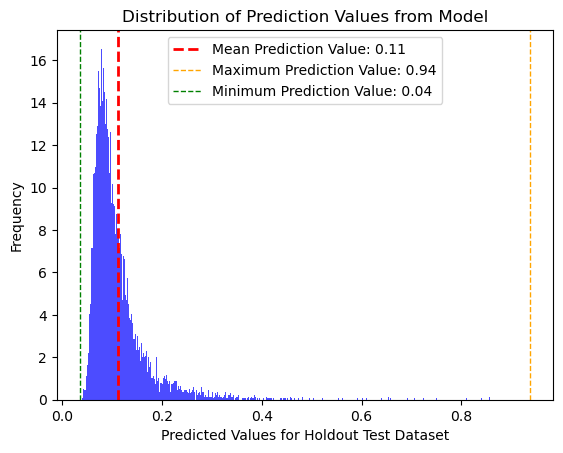

The mean predictive value for the test dataset is: 0.11274402637497526


In [40]:
plt.hist(test_dataset.predictions, bins=1000, density=True, alpha=0.7, color='blue')
plt.xlabel('Predicted Values for Holdout Test Dataset')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Values from Model')

mean_value = np.mean(test_dataset.predictions)
max_value = np.max(test_dataset.predictions)
min_value = np.min(test_dataset.predictions)


# Add mean line to the histogram
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label=f'Mean Prediction Value: {mean_value:.2f}')

plt.axvline(max_value, color='orange', linestyle='dashed', linewidth=1, label=f'Maximum Prediction Value: {max_value:.2f}')

plt.axvline(min_value, color='green', linestyle='dashed', linewidth=1, label=f'Minimum Prediction Value: {min_value:.2f}')


# Display legend
plt.legend()

# Show the histogram
plt.show()

print('The mean predictive value for the test dataset is: {}'.format(mean_value))

As we can see here, our algorithm is hesitant to place much predictive weight behind any particular patient record, and so the majority of our predictions are centered near 0.1 and skew right. As the dataset is weighted heavily towards those who were not readmitted (i.e about 1 in 10 patients being readmitted), this makes sense.

We will therefore institute a prediction/rounding cutoff value lower than 0.5 to determine which records are predicted as being readmitted. As the mean prediction is around .11, using this value instead of 0.5 would likely predict around half of records as being classified as readmissions.

We will therefore use a average of these predictions is likely a good place to start. Let us try this value, as well with a few other values to see which cutoff value gives us the best statistical outcome.

As mentioned earlier, optimizing the Area Under the Curve (AUC) metric will be our highest priority, as this metric takes into account both false positives and false negatives.

#### Here we create new lists that will cut probabilities (ranging from 7% to 15%), centering on cutoff values close to the mean of 11%. 

This function evaluates our model at a variety of cutoff prediction values.

In [41]:
def Linear_Learner_Statistical_Evaluation(probability_rounding_threshold_values, names_of_levels):
    
    '''The CSV_Reader() function takes different readmission predictions, based off of different likelihood roundoff 
    values, and computes different 
    
    Arguments 
    --------- 
    probability_rounding_threshold_values: A list of probabilities for each likelihood cutoff value
    subfolder: A list of names for each item of the probability_rounding_threshold_values list, representing 
        the implimented likelihood cutoff value
    
    Return
    ---------
    For each prediction list, the following is computed:
    -The likelihood cutoff value being used
    -The number of predicted positived
    -The accuracy of the predictions
    -The precision of the predictions
    -The recall of the predictions
    -The F1 score of the predictions
    -The ROC AUC score of the predictions
    '''
    
    for i, j in zip(probability_rounding_threshold_values, names_of_levels):
        y_test = test_dataset['readmitted']
        scores = precision_recall_fscore_support(y_test, i, average='macro', labels=np.unique(i))
        acc = accuracy_score(y_test, i)
        roc = roc_auc_score(y_test, i)
        positives = sum(i)

        
        print()
        print('The cutoff percentage being used for predictions is: {}'.format(j))
        print('Number of predicted readmissions: {}'.format(positives))
        print('Accuracy is: {}'.format(acc))
        print('Precision is: {}'.format(scores[0]))
        print('Recall is: {}'.format(scores[1]))
        print('F1 score is: {}'.format(scores[2]))     
        print('ROC AUC score (i.e. the metric of primary interest) is: {}'.format(roc))

Here we define our thresholds, and evaluate our model accordingly.

In [42]:
thresholds = [0.15, 0.14, 0.13, 0.12, 0.11, 0.1, 0.09, 0.08, 0.07]

for threshold in thresholds:
    threshold_str = str(threshold).replace(".", "_")  # Convert threshold to a string and replace "." with "_"
    variable_name = f"pred_{threshold_str}"
    output_variable_name = f"pred_{threshold_str[2:]}"  # Remove the "0_" part
    globals()[output_variable_name] = [1 if i >= threshold else 0 for i in test_dataset["predictions"]]

threshold_list = [pred_15, pred_14, pred_13, pred_12, pred_11, pred_1, pred_09, pred_08, pred_07]
threshold_list_names = ["pred_15", "pred_14", "pred_13", "pred_12", "pred_11", "pred_1", "pred_09", "pred_08", "pred_07"]

In [43]:
threshold_list = [pred_15, pred_14, pred_13, pred_12, pred_11, pred_1, pred_09, pred_08, pred_07]
threshold_list_names = ["pred_15", "pred_14", "pred_13", "pred_12", "pred_11", "pred_1", "pred_09", "pred_08", "pred_07"]

In [45]:
Linear_Learner_Statistical_Evaluation(threshold_list, threshold_list_names)


The cutoff percentage being used for predictions is: pred_15
Number of predicted readmissions: 2259
Accuracy is: 0.805100546011453
Precision is: 0.5656254205686854
Recall is: 0.584588245564011
F1 score is: 0.5720106728397997
ROC AUC score (i.e. the metric of primary interest) is: 0.5845882455640111

The cutoff percentage being used for predictions is: pred_14
Number of predicted readmissions: 2754
Accuracy is: 0.7834598481821814
Precision is: 0.5626186674568356
Recall is: 0.5945812280490235
F1 score is: 0.5694563685958902
ROC AUC score (i.e. the metric of primary interest) is: 0.5945812280490235

The cutoff percentage being used for predictions is: pred_13
Number of predicted readmissions: 3394
Accuracy is: 0.7541616726594753
Precision is: 0.5590473867693322
Recall is: 0.6041773175598153
F1 score is: 0.5619568767369777
ROC AUC score (i.e. the metric of primary interest) is: 0.6041773175598153

The cutoff percentage being used for predictions is: pred_12
Number of predicted readmission

It looks as though a cutoff value of 10% works best (AUC: 0.6161640667456368) so let us investigate the cutoff value to the 0.001 place to see if our AUC improves any.

In [46]:
mp_thresholds = [0.104, 0.103, 0.102, 0.101, 0.10, 0.999, 0.998, 0.997, 0.996]

for threshold in mp_thresholds:
    threshold_str = str(threshold).replace(".", "_")  # Convert threshold to a string and replace "." with "_"
    variable_name = f"pred_{threshold_str}"
    output_variable_name = f"pred_{threshold_str[2:]}"  # Remove the "0_" part
    globals()[output_variable_name] = [1 if i >= threshold else 0 for i in test_dataset["predictions"]]

In [47]:
more_precise_rounding_threshold_predictions = [pred_104, pred_103, pred_102, pred_101, pred_1, pred_999, pred_998, pred_997, pred_996]
more_precise_names_of_levels = ['10.4%', '10.3%','10.2%', '10.1%', '10%', '9.9%', '9.8%', '9.7%', '9.6%']

In [48]:
Linear_Learner_Statistical_Evaluation(more_precise_rounding_threshold_predictions, more_precise_names_of_levels)


The cutoff percentage being used for predictions is: 10.4%
Number of predicted readmissions: 6171
Accuracy is: 0.6154614462644826
Precision is: 0.5477705611613054
Recall is: 0.6166317967306931
F1 score is: 0.5018929302876043
ROC AUC score (i.e. the metric of primary interest) is: 0.6166317967306931

The cutoff percentage being used for predictions is: 10.3%
Number of predicted readmissions: 6302
Accuracy is: 0.6087361832467706
Precision is: 0.5475326240247456
Recall is: 0.6167595627281408
F1 score is: 0.4985429715924068
ROC AUC score (i.e. the metric of primary interest) is: 0.6167595627281408

The cutoff percentage being used for predictions is: 10.2%
Number of predicted readmissions: 6464
Accuracy is: 0.6002130776401652
Precision is: 0.5470724569826635
Recall is: 0.6163971938526354
F1 score is: 0.4941012640501132
ROC AUC score (i.e. the metric of primary interest) is: 0.6163971938526354

The cutoff percentage being used for predictions is: 10.1%
Number of predicted readmissions: 662

It looks as though a cutoff value of 10.3% works best (AUC: 0.6167595627281408) so let us investigate the cutoff value to the 0.001 place to see if our AUC improves any.

In [49]:
emp_thresholds = [0.1034, 0.1033, 0.1032, 0.1031, 0.103, 0.1029, 0.1028, 0.1027, 0.1026]

for threshold in emp_thresholds:
    threshold_str = str(threshold).replace(".", "_")  # Convert threshold to a string and replace "." with "_"
    variable_name = f"pred_{threshold_str}"
    output_variable_name = f"pred_{threshold_str[2:]}"  # Remove the "0_" part
    globals()[output_variable_name] = [1 if i >= threshold else 0 for i in test_dataset["predictions"]]

In [50]:
emp_threshold_list = [pred_1034, pred_1033, pred_1032, pred_1031, pred_103, pred_1029, pred_1028, pred_1027, pred_1026]
emp_threshold_variable_names = ["pred_1034", "pred_1033", "pred_1032", "pred_1031", "pred_103", "pred_1029", "pred_1028", "pred_1027", "pred_1026"]

In [51]:
Linear_Learner_Statistical_Evaluation(emp_threshold_list, emp_threshold_variable_names)


The cutoff percentage being used for predictions is: pred_1034
Number of predicted readmissions: 6246
Accuracy is: 0.611532827273938
Precision is: 0.5475497752213948
Recall is: 0.6165075636397201
F1 score is: 0.49987751381796885
ROC AUC score (i.e. the metric of primary interest) is: 0.61650756363972

The cutoff percentage being used for predictions is: pred_1033
Number of predicted readmissions: 6269
Accuracy is: 0.6105340258356639
Precision is: 0.5476960828884739
Recall is: 0.6169888438863187
F1 score is: 0.49952263078867754
ROC AUC score (i.e. the metric of primary interest) is: 0.6169888438863187

The cutoff percentage being used for predictions is: pred_1032
Number of predicted readmissions: 6279
Accuracy is: 0.6098681582101478
Precision is: 0.5475218945643878
Recall is: 0.6166140874779842
F1 score is: 0.49907042156740145
ROC AUC score (i.e. the metric of primary interest) is: 0.6166140874779842

The cutoff percentage being used for predictions is: pred_1031
Number of predicted r

It looks as though a cutoff value of 10.27% works best (AUC: 0.6182063550100548) so let us investigate the cutoff value to the 0.001 place to see if our AUC improves any.

In [52]:
vp_thresholds = [0.10274, 0.10273, 0.10272, 0.10271, 0.1027, 0.10269, 0.10268, 0.10267, 0.10266]

for threshold in vp_thresholds:
    threshold_str = str(threshold).replace(".", "_")  # Convert threshold to a string and replace "." with "_"
    variable_name = f"pred_{threshold_str}"
    output_variable_name = f"pred_{threshold_str[2:]}"  # Remove the "0_" part
    globals()[output_variable_name] = [1 if i >= threshold else 0 for i in test_dataset["predictions"]]

In [53]:
vp_threshold_list = [pred_10274, pred_10273, pred_10272, pred_10271, pred_1027, pred_10269, pred_10268, pred_10267, pred_10266]
vp_threshold_name_list = ["pred_10274", "pred_10273", "pred_10272", "pred_10271", "pred_1027", "pred_10269", "pred_10268", "pred_10267", "pred_10266"]

In [54]:
Linear_Learner_Statistical_Evaluation(vp_threshold_list, vp_threshold_name_list)


The cutoff percentage being used for predictions is: pred_10274
Number of predicted readmissions: 6338
Accuracy is: 0.607138100945532
Precision is: 0.5477292441320221
Recall is: 0.6174252696367886
F1 score is: 0.49793723303717174
ROC AUC score (i.e. the metric of primary interest) is: 0.6174252696367886

The cutoff percentage being used for predictions is: pred_10273
Number of predicted readmissions: 6340
Accuracy is: 0.6070049274204288
Precision is: 0.5476947217046187
Recall is: 0.6173503183551217
F1 score is: 0.49784674520169475
ROC AUC score (i.e. the metric of primary interest) is: 0.6173503183551217

The cutoff percentage being used for predictions is: pred_10272
Number of predicted readmissions: 6345
Accuracy is: 0.6066719936076708
Precision is: 0.5476084716051745
Recall is: 0.6171629401509544
F1 score is: 0.49762055163904717
ROC AUC score (i.e. the metric of primary interest) is: 0.6171629401509544

The cutoff percentage being used for predictions is: pred_10271
Number of predi

None of these above results improved performance any. Therefore we will stick with the predctive-cutoff value of 10.27%.

From the above results, we can see that a cutoff value of 10.27% (i.e. those predicted as being at 10.58% or greater risk of readmission) gives us the greatest Area-Under-The-Curve value of 0.6138.

This can be roughly interpreted as: "Given a random readmitted/positive record, and random not-readmitted/negative record, the algorithm will correctly identify the positive record as being more likely to be readmitted than the negative record, 62% of the time.

This value of 0.62 is fairly close to the AUC value of 0.66 that we recieved from our best hyperparameter tuning session off of the validation data subset. This indicates that while there is likely some degree of overfitting present, generally, generally our model does a good job at providing generalizable, unbiased predictions across the entirity of the patient population.

Although the accuracy and precission have decreased due to our lower prediction cutoff point, we are able to predict these costly readmissions demonstratably better with the algorithm than without.

### 3.6 Evaluate Model

In [55]:
optimal_cutoff = pred_1027

In [56]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

def Plot_Confusion_Matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None, 
                          cmap=None):
    
    '''The Plot_Confusion_Matrix() function produces a confusion matrix with which to view our final results.
    
    Arguments 
    --------- 
    y_true: the actual readmission values for the test dataset
    y_pred: the predicted readmission values for the test dataset
    classes: The names for the outcome possibilities (i.e. readmitted/not readmitted) 
    title: chart title
    cmap: sets the color gradient
    
    Return
    ---------
    Returns the specified confusion matrix '''
    
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
            plt.cm.Greens
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Actual',
           xlabel='Predicted')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

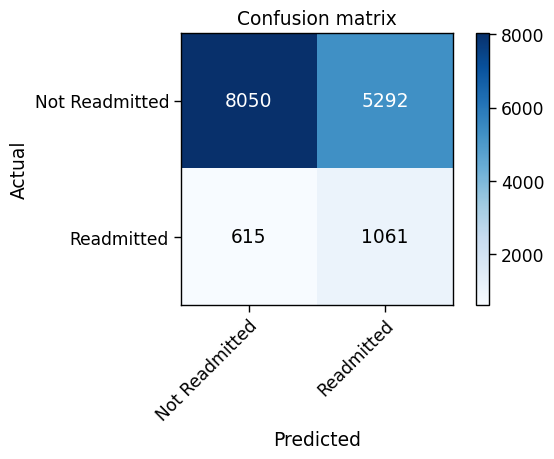

In [57]:
%matplotlib inline
sns.set_context("paper", font_scale=1.4)

y_test = test_dataset['readmitted']
y_pred = optimal_cutoff

class_names = np.array(['Not Readmitted', 'Readmitted'])

# Plot non-normalized confusion matrix
Plot_Confusion_Matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)
plt.grid(False)

# Save the table as a PNG image in memory
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Upload the image to S3
file_path = 'image_outputs/'
file_name = 'll_confusion_matrix.png'  # Specify the desired file name in S3
file_key = file_path + file_name

#s3_client = boto3.client('s3')
s3_client.upload_fileobj(buffer, bucket, file_key)


plt.show()

#### Our final predictive statistics:

In [58]:
Linear_Learner_Statistical_Evaluation([optimal_cutoff], ['10.27% Cutoff'])


The cutoff percentage being used for predictions is: 10.27% Cutoff
Number of predicted readmissions: 6353
Accuracy is: 0.6066719936076708
Precision is: 0.5480162626777414
Recall is: 0.6182063550100549
F1 score is: 0.4979386731776368
ROC AUC score (i.e. the metric of primary interest) is: 0.6182063550100548


For further discussion of these results, please see the accompanying assessment located here:<br>
https://wbst-bkt.s3.amazonaws.com/index.html